In [9]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Instead of doing an IC50 curve, where the dose-response is inhibition, I'd like to try a dose-response curve where the response is activation as a function of concentration.

In [10]:
x1 = np.vstack([np.linspace(-2, 2, 10)] * 5)
x2 = np.vstack([np.linspace(-2, 2, 10)] * 5)
x3 = np.vstack([np.linspace(-2, 2, 10)] * 5)

In [11]:
def dose_response(x, lower: float, upper: float, slope: float, c50: float):
    """
    :param x: Array of x-values.
    :param lower: Lower-plateau value
    :param upper: Upper-plateau value
    :param slope: Slope of dose response curve
    :param c50: The midpoint value of the curve.
    """
    
    return lower + (upper - lower) / (1 + np.exp(slope * (c50 - x)))


def noise(x, sd):
    return np.random.normal(0, scale=sd, size=x.shape)

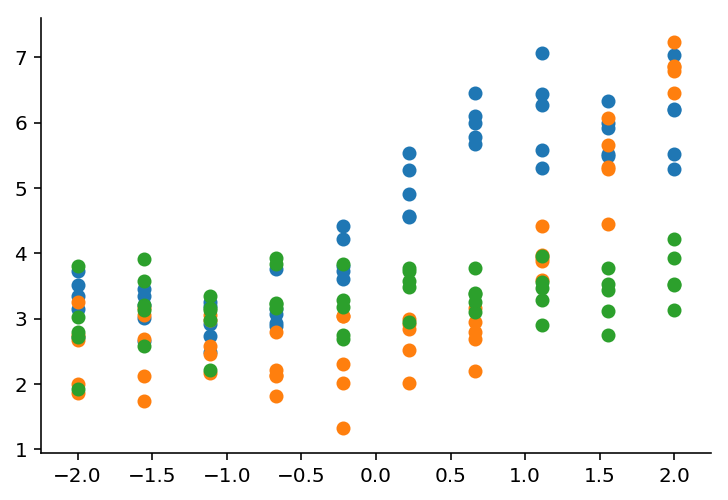

In [13]:
y1 = dose_response(x1, lower=3, upper=6, slope=4, c50=0) + noise(x1, 0.5)
y2 = dose_response(x2, lower=2.5, upper=8, slope=3, c50=1.5) + noise(x2, 0.5)
y3 = dose_response(x3, lower=3.2, upper=3.4, slope=1.5, c50=0.0) + noise(x3, 0.5)
plt.scatter(x1, y1)
plt.scatter(x2, y2)
plt.scatter(x3, y3)

Here, we have three separate curves.

- The blue one shows a nice and clean dose response relationship within the same bounds 
- The orange one shows an example where we do not hit 

In [14]:
df = pd.DataFrame({'concentration': np.concatenate([x1.flatten(), x2.flatten(), x3.flatten()]),
                   'response': np.concatenate([y1.flatten(), y2.flatten(), y3.flatten()]),
                   'molecule': ([0] * len(x1.flatten()) + [1] * len(x2.flatten()) + [2] * len(x3.flatten()))
                  }
                 )

In [18]:
with pm.Model() as model:
    lower = pm.Normal('lower', mu=0, sd=10, shape=(3,))
    upper = pm.Normal('upper', mu=10, sd=10, shape=(3,))
    c50 = pm.Normal('c50', mu=0, sd=10, shape=(3,))
    slope = pm.HalfNormal('slope', sd=10, shape=(3,))
    
    mu = dose_response(df['concentration'], 
                       lower[df['molecule'].values], 
                       upper[df['molecule'].values], 
                       slope[df['molecule'].values], 
                       c50[df['molecule'].values])
    
    sd = pm.HalfNormal('sd', sd=10, shape=(3,))
    y = pm.Normal('like', mu=mu, sd=sd[df['molecule'].values], observed=df['response'])

In [ ]:
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/ericmjl/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.6.7-64/lock_dir/lock


In [ ]:
pm.traceplot(trace, varnames=['upper'])
plt.show()

In [ ]:
with pm.Model() as model_v2:
    # Group priors on lower
    lower_mu = pm.Normal('lower_mu', mu=0, sd=3)
    lower_sd = pm.Exponential('lower_sd', lam=5)
    # Prior on lower
    lower = pm.Normal('lower', mu=lower_mu, sd=lower_sd, shape=(3,))
    
    # Group prior on upper
    upper_mu = pm.Normal('upper_mu', mu=7, sd=3)
    upper_sd = pm.Exponential('upper_sd', lam=5)
    # Prior on upper
    upper = pm.Normal('upper', mu=upper_mu, sd=upper_sd, shape=(3,))
    
    # Group prior on c50
    c50_mu = pm.Normal('c50_mu', mu=0, sd=3)
    c50_sd = pm.Exponential('c50_sd', lam=5)
    # Prior on c50
    c50 = pm.Normal('c50', mu=c50_mu, sd=c50_sd, shape=(3,))
    
    # Group prior on slope
    slope_sd = pm.Exponential('slope_sd', lam=5)
    # Prior on slope
    slope = pm.HalfNormal('slope', sd=slope_sd, shape=(3,))
    
    # Transformation
    mu = dose_response(df['concentration'], 
                       lower[df['molecule'].values], 
                       upper[df['molecule'].values], 
                       slope[df['molecule'].values], 
                       c50[df['molecule'].values])
    
    # Prior on SD
    sd = pm.HalfNormal('sd', sd=10, shape=(3,))
    
    # Likelihood
    y = pm.Normal('like', mu=mu, sd=sd[df['molecule'].values], observed=df['response'])

In [ ]:
with model_v2:
    trace_v2 = pm.sample(2000)

In [ ]:
pm.traceplot(trace_v2, varnames=['upper'])

In [ ]:
with pm.Model() as model_v3:
    # Main change here: switched lower and upper to gamma-distributed.
    
    # Group priors on lower
    lower_mu = pm.HalfNormal('lower_mu', sd=10)
    lower_sd = pm.Exponential('lower_sd', lam=5)
    # Prior on lower
    lower = pm.Gamma('lower', mu=lower_mu, sd=lower_sd, shape=(3,))
    
    # Group prior on upper
    upper_mu = pm.HalfNormal('upper_mu', sd=10)
    upper_sd = pm.Exponential('upper_sd', lam=5)
    # Prior on upper
    upper = pm.Gamma('upper', mu=upper_mu, sd=upper_sd, shape=(3,))
    
    # Group prior on c50
    c50_mu = pm.Normal('c50_mu', mu=0, sd=3)
    c50_sd = pm.Exponential('c50_sd', lam=5)
    # Prior on c50
    c50 = pm.Normal('c50', mu=c50_mu, sd=c50_sd, shape=(3,))
    
    # Group prior on slope
    slope_sd = pm.Exponential('slope_sd', lam=5)
    # Prior on slope
    slope = pm.HalfNormal('slope', sd=slope_sd, shape=(3,))
    
    # Transformation
    mu = dose_response(df['concentration'], 
                       lower[df['molecule'].values], 
                       upper[df['molecule'].values], 
                       slope[df['molecule'].values], 
                       c50[df['molecule'].values])
    
    # Prior on SD
    sd = pm.HalfNormal('sd', sd=10, shape=(3,))
    
    # Likelihood
    y = pm.Normal('like', mu=mu, sd=sd[df['molecule'].values], observed=df['response'])

In [ ]:
with model_v3:
    trace_v3 = pm.sample(2000)

In [ ]:
pm.traceplot(trace_v3, varnames=['upper'])

In [ ]:
upper = trace_v3['upper'].mean(axis=0)

In [ ]:
upper